In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
import re
import pickle
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar
from camel_tools.ner import NERecognizer

In [24]:
# Télécharger les stopwords arabes
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

# Lire les stopwords en Darija
def load_darija_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        darija_stopwords = set(file.read().splitlines())
    return darija_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Fonction pour normaliser le texte
def normalize_text(text):
    text = normalize_alef_maksura_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_teh_marbuta_ar(text)
    return text

In [26]:
# nettoyege du texte
def clean_text(text, stopwords):
    # Suppression des diacritiques
    text = dediac_ar(text)
    
    # Normalisation
    text = normalize_text(text)
    
    # Supprimer les caractères non arabes (y compris les chiffres et la ponctuation)
    text = re.sub(r'[^ء-ي\s]', '', text)
    
    # Tokenisation
    words = simple_word_tokenize(text)
    
    # Supprimer les mots d'arrêt
    words = [word for word in words if word not in stopwords]
    
    return ' '.join(words)

In [28]:
# Charger les données prétraitées
def preprocess_data(file_path, stopwords_file):
    # Charger le dataset
    df = pd.read_csv(file_path)

    # Charger les stopwords en Darija
    darija_stopwords = load_darija_stopwords(stopwords_file)

    # Combiner les deux listes de stopwords
    combined_stopwords = arabic_stopwords.union(darija_stopwords)

    # Application du nettoyage à la colonne des commentaires
    df['cleaned_comment'] = df['text'].apply(lambda x: clean_text(str(x), combined_stopwords))
    
    # Encodage des labels
    label_encoder = LabelEncoder()
    df['labelenc'] = label_encoder.fit_transform(df['label'])

    # Vectorisation des textes
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(df['cleaned_comment'])
    y = df['labelenc']
    
    # Sauvegarde des objets nécessaires pour l'entraînement
    with open('vectorizer.pkl', 'wb') as vec_file:
        pickle.dump(vectorizer, vec_file)
    with open('label_encoder.pkl', 'wb') as le_file:
        pickle.dump(label_encoder, le_file)
    
    return X, y, label_encoder


data_file_path = 'MoroccoEarthquake_comments_Clean2.csv'
stopwords_file_path = 'darija_stopwords.txt'
X, y, label_encoder = preprocess_data(data_file_path, stopwords_file_path)

In [29]:
# Appliquer SMOTE pour suréchantillonner les classes minoritaires avec un random_state fixe
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [30]:
# Initialiser le modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [31]:
# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [32]:
# Calculer les métriques d'évaluation
cv_accuracy = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='precision_macro')
cv_recall = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='recall_macro')
cv_f1 = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='f1_macro')

# Afficher les résultats de la validation croisée
print("CV Accuracy: ", cv_accuracy)
print("CV Precision: ", cv_precision)
print("CV Recall: ", cv_recall)
print("CV F1-Score: ", cv_f1)

CV Accuracy:  [0.88909953 0.86255924 0.86729858 0.87014218 0.87855787]
CV Precision:  [0.88953117 0.8632995  0.86983054 0.87207706 0.87944466]
CV Recall:  [0.88903139 0.8624026  0.8674026  0.87016234 0.87865801]
CV F1-Score:  [0.88853372 0.8617818  0.86709587 0.86998514 0.87728292]


In [33]:
# Entraîner le modèle Random Forest sur l'ensemble complet de données rééchantillonnées
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [34]:
# Sauvegarder le modèle entraîné
with open('rf_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)


In [35]:
# Division des données pour évaluation sur un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [36]:
# Calculer les métriques sur l'ensemble de test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1-Score: {f1}')

Test Accuracy: 0.8654028436018958
Test Precision: 0.8643491265308842
Test Recall: 0.8666777258834966
Test F1-Score: 0.8640764093737264


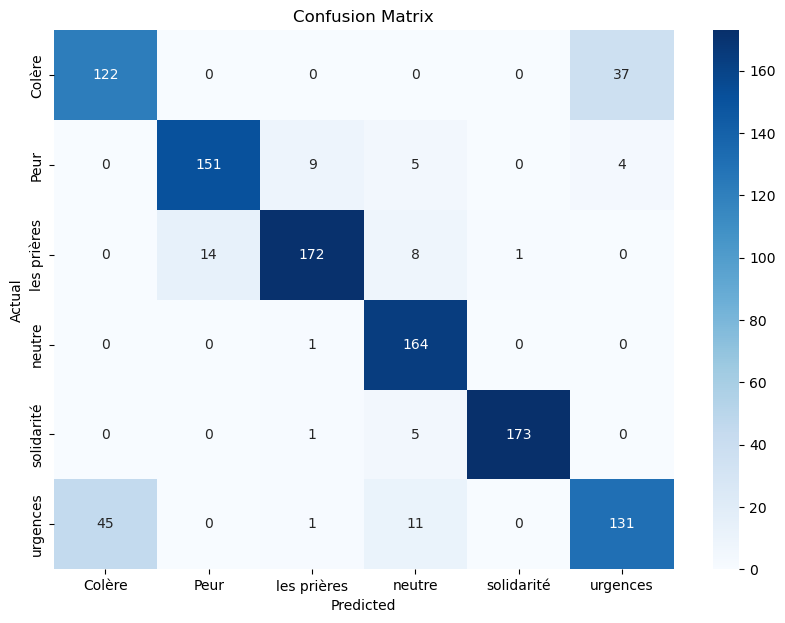

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Test Random Forest

In [48]:
# Exemple de phrase
example_sentence = "كان قوي بزاف "
#example_sentence = " كل التضامن مع المتضررين مستاعد نجي نعاون الناس لي محتاجين "
#example_sentence = "اين الحكومة الفاشلة"
#example_sentence = "مولاي براهيم مازال ماوصلاتنا حتى مساعدة والو"
#example_sentence = "نهار تكون الحكومه فصف المواطن غيكون كلشي علي احسن ما يرام وتحيد بعض المفسدين من طريق وديك ساعه غيبان المغرب دوله متقدمه "
# Nettoyer la phrase exemple
cleaned_example = clean_text(example_sentence, combined_stopwords)
# Vectoriser la phrase nettoyée
example_vector = vectorizer.transform([cleaned_example])

# Prédire le sentiment
predicted_label = optimized_svm_model.predict(example_vector)
# Convertir le label numérique en sentiment correspondant
predicted_sentiment = label_encoder.inverse_transform([predicted_label])
print(predicted_sentiment[0])

Peur


C:\Users\zakar\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar
from camel_tools.tokenizers.word import simple_word_tokenize

# Charger le modèle entraîné
with open('rf_model.pkl', 'rb') as model_file:
    rf_model = pickle.load(model_file)

# Charger le vectorizer et le label encoder
with open('vectorizer.pkl', 'rb') as vec_file:
    vectorizer = pickle.load(vec_file)
with open('label_encoder.pkl', 'rb') as le_file:
    label_encoder = pickle.load(le_file)


In [42]:
# Charger les stopwords en arabe et en darija
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))
darija_stopwords = load_darija_stopwords('darija_stopwords.txt')
combined_stopwords = arabic_stopwords.union(darija_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Fonction pour normaliser le texte
def normalize_text(text):
    text = normalize_alef_maksura_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_teh_marbuta_ar(text)
    return text

In [44]:
# Fonction pour nettoyer le texte
def clean_text(text, stopwords):
    # Supprimer les diacritiques
    text = dediac_ar(text)
    
    # Normalisation
    text = normalize_text(text)
    
    # Supprimer les caractères non arabes (y compris les chiffres et la ponctuation)
    text = re.sub(r'[^ء-ي\s]', '', text)
    
    # Tokenisation
    words = simple_word_tokenize(text)
    
    # Supprimer les mots d'arrêt
    words = [word for word in words if word not in stopwords]
    
    return ' '.join(words)


In [48]:
# Exemple de commentaire
example_comment = "ياربي السلامة "

# Nettoyer et vectoriser le commentaire
cleaned_comment = clean_text(example_comment, combined_stopwords)
vectorized_comment = vectorizer.transform([cleaned_comment])

# Faire une prédiction
predicted_label_enc = rf_model.predict(vectorized_comment)
predicted_label = label_encoder.inverse_transform(predicted_label_enc)

# Afficher le résultat
print(f"Commentaire: {example_comment}")
print(f"Sentiment prédit: {predicted_label[0]}")

Commentaire: ياربي السلامة 
Sentiment prédit: Peur
